# Acoustic Anomaly Detection Notebook
#
This notebook trains and evaluates three different models on Mel-spectrogram frames:
1. **K-means Clustering** (unsupervised)
2. **One-Class SVM** (unsupervised, scikit-learn)
3. **LSTM Autoencoder** (unsupervised, PyTorch)
#
The data is prepared using our usual logic:
- Generate Mel-spectrograms from anomalous and normal recordings.
- Slice them into overlapping frames.
- Split into train/validation/test sets.
#
In the **Training** section, each model is trained and then saved.
In the **Evaluation** section, the saved models are loaded and evaluated.
Evaluation includes metrics such as ROC AUC, precision, recall, F1, confusion matrices and ROC curves.
Additionally, training and inference times are recorded.


## 1. Imports

In [20]:
import os
import time
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
import joblib  # For saving/loading scikit-learn models


## 2. Data Preparation: Mel-Spectrogram Frames

In [21]:
import pywt


def wavelet_denoise(audio, wavelet='db4', level=3, threshold_multiplier=1.5):
    """Apply wavelet denoising to audio signal."""
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(audio, wavelet, level=level)
    
    # Estimate noise level (using detail coefficients from the first level)
    detail_coeffs = coeffs[1]
    sigma = np.median(np.abs(detail_coeffs)) / 0.6745
    
    # Calculate a more conservative threshold
    threshold = sigma * threshold_multiplier
    
    # Apply soft thresholding only to the finest detail levels
    # (preserving more of the signal characteristics)
    new_coeffs = list(coeffs)
    
    # Only apply thresholding to highest frequency details (levels 1-2)
    for i in range(1, min(3, len(coeffs))):
        coeffs_i = coeffs[i]
        # Soft thresholding
        sign = np.sign(coeffs_i)
        magnitude = np.abs(coeffs_i)
        thresholded = sign * np.maximum(magnitude - threshold, 0)
        new_coeffs[i] = thresholded
    
    # Reconstruct signal
    denoised_audio = pywt.waverec(new_coeffs, wavelet)
    
    # Ensure the denoised signal has the same length as the original
    if len(denoised_audio) > len(audio):
        denoised_audio = denoised_audio[:len(audio)]
    elif len(denoised_audio) < len(audio):
        denoised_audio = np.pad(denoised_audio, (0, len(audio) - len(denoised_audio)))
    
    return denoised_audio

In [22]:
def normalize_audio(audio, target_dBFS=-20):
    """Normalize audio to a target dBFS level."""
    # Calculate current RMS (root mean square)
    rms = np.sqrt(np.mean(audio**2))
    
    # Calculate current dBFS
    current_dBFS = 20 * np.log10(rms) if rms > 0 else -80
    
    # Calculate gain needed
    gain = 10**((target_dBFS - current_dBFS) / 20)
    
    # Apply gain
    normalized_audio = audio * gain
    
    # Ensure no clipping
    if np.max(np.abs(normalized_audio)) > 1.0:
        normalized_audio = normalized_audio / np.max(np.abs(normalized_audio))
    
    return normalized_audio

In [23]:
# Paths to audio files (update if necessary)
anomalous_audio_path = "../../Data/raw/13_real/Anomaly_knackgeräusche.wav"
normal_audio_path = "../../Data/raw/13_real/Normal_knackgeräusche.wav"

# Paths for saving frames and datasets
output_anomalous_frames_path = "../../Data/frames/anomalous_frames_real.npy"
output_normal_frames_path = "../../Data/frames/normal_frames_real.npy"
train_frames_path = "../../Data/datasets/train_frames_real.npy"
val_frames_path = "../../Data/datasets/val_frames_real.npy"
test_frames_path = "../../Data/datasets/test_frames_real.npy"
test_labels_path = "../../Data/datasets/test_labels_real.npy"

os.makedirs(os.path.dirname(output_anomalous_frames_path), exist_ok=True)
os.makedirs(os.path.dirname(train_frames_path), exist_ok=True)


def generate_mel_spectrogram(audio_path):
    """Generate a normalized Mel-spectrogram from an audio file."""
    # Load audio
    audio, sr = librosa.load(audio_path, sr=None)
    
    # 1. Normalize audio amplitude
    audio = normalize_audio(audio)
    
    # 2. Apply wavelet denoising
    audio = wavelet_denoise(audio, wavelet='db4', level=5)
    
    # 3. Generate mel spectrogram
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    mel = librosa.feature.melspectrogram(S=np.abs(stft) ** 2, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # 4. Normalize mel spectrogram
    mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())
    
    return mel_db_norm, sr


# Generate Mel-spectrograms
mel_db_anomalous, sr_anomalous = generate_mel_spectrogram(anomalous_audio_path)
mel_db_normal, sr_normal = generate_mel_spectrogram(normal_audio_path)
assert sr_anomalous == sr_normal, "Sampling rates do not match!"


def generate_frames(mel_spectrogram, frame_size, hop_size):
    """Generate overlapping frames from a Mel-spectrogram."""
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]
    return frames


# Adjustable parameters
time_per_frame = 0.6  # seconds
hop_ratio = 0.2
hop_length = 512
frame_size = int((time_per_frame * sr_anomalous) / hop_length)
hop_size = int(frame_size * hop_ratio)

# Generate frames
anomalous_frames = generate_frames(mel_db_anomalous, frame_size, hop_size)
normal_frames = generate_frames(mel_db_normal, frame_size, hop_size)

# Save frames
np.save(output_anomalous_frames_path, anomalous_frames)
np.save(output_normal_frames_path, normal_frames)


## 3. Train/Validation/Test Split

In [24]:
anomalous_frames = np.load(output_anomalous_frames_path)
normal_frames = np.load(output_normal_frames_path)

# Split normal frames into training, validation, and test sets
normal_train_val, normal_test = train_test_split(normal_frames, test_size=0.15, random_state=42)
normal_train, normal_val = train_test_split(normal_train_val, test_size=0.1765, random_state=42)

# Combine normal_test and anomalous_frames for testing
test_frames = np.concatenate([normal_test, anomalous_frames], axis=0)
test_labels = np.concatenate([np.zeros(len(normal_test)), np.ones(len(anomalous_frames))])

# Shuffle the test set
indices = np.arange(len(test_frames))
np.random.shuffle(indices)
test_frames = test_frames[indices]
test_labels = test_labels[indices]

# Save datasets
np.save(train_frames_path, normal_train)
np.save(val_frames_path, normal_val)
np.save(test_frames_path, test_frames)
np.save(test_labels_path, test_labels)

# For convenience when training models:
train_frames = np.load(train_frames_path)
val_frames = np.load(val_frames_path)
print("Train frames shape:", train_frames.shape)
print("Val frames shape:", val_frames.shape)
print("Test frames shape:", test_frames.shape)


Train frames shape: (21687, 128, 51)
Val frames shape: (4649, 128, 51)
Test frames shape: (4691, 128, 51)


## 4. Model Training

In this section, we train each model and save the trained model to disk.

### 4.1. K-means Clustering Training

In [25]:
# Flatten frames for K-means
X_train_kmeans = train_frames.reshape(len(train_frames), -1)
X_val_kmeans = val_frames.reshape(len(val_frames), -1)
X_test_kmeans = test_frames.reshape(len(test_frames), -1)

scaler_kmeans = StandardScaler()
X_train_kmeans = scaler_kmeans.fit_transform(X_train_kmeans)
X_val_kmeans = scaler_kmeans.transform(X_val_kmeans)
X_test_kmeans = scaler_kmeans.transform(X_test_kmeans)

n_clusters = 1
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Measure training time for K-means
start_time = time.time()
kmeans.fit(X_train_kmeans)
training_time_kmeans = time.time() - start_time
print(f"K-means training time: {training_time_kmeans:.4f} seconds")

# Save the scaler and K-means model for later evaluation
joblib.dump(scaler_kmeans, "../../Models/KMeans/scaler_kmeans_real.pkl")
joblib.dump(kmeans, "../../Models/KMeans/kmeans_model_real.pkl")
print("K-means model saved.")


K-means training time: 5.2506 seconds
K-means model saved.


### 4.2. One-Class SVM Training

In [26]:
# Flatten frames for One-Class SVM
X_train_ocsvm = normal_train.reshape(len(normal_train), -1)
X_test_ocsvm = test_frames.reshape(len(test_frames), -1)

scaler_ocsvm = StandardScaler()
X_train_ocsvm = scaler_ocsvm.fit_transform(X_train_ocsvm)
X_test_ocsvm = scaler_ocsvm.transform(X_test_ocsvm)

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)

start_time = time.time()
ocsvm.fit(X_train_ocsvm)
training_time_ocsvm = time.time() - start_time
print(f"One-Class SVM training time: {training_time_ocsvm:.4f} seconds")

# Save the scaler and One-Class SVM model
joblib.dump(scaler_ocsvm, "../../Models/OCSVM/scaler_ocsvm_real.pkl")
joblib.dump(ocsvm, "../../Models/OCSVM/ocsvm_model_real.pkl")
print("One-Class SVM model saved.")



One-Class SVM training time: 55.5363 seconds
One-Class SVM model saved.


### 4.3. LSTM Autoencoder Training

We reshape frames for the LSTM autoencoder and then train the model.

In [27]:
def reshape_for_lstm(frames):
    # (N, 128, frame_size) -> (N, frame_size, 128)
    return np.transpose(frames, (0, 2, 1))


train_frames_lstm = reshape_for_lstm(normal_train)
val_frames_lstm = reshape_for_lstm(normal_val)
test_frames_lstm = reshape_for_lstm(test_frames)

# Convert to PyTorch tensors
train_frames_tensor_lstm = torch.tensor(train_frames_lstm, dtype=torch.float32)
val_frames_tensor_lstm = torch.tensor(val_frames_lstm, dtype=torch.float32)
test_frames_tensor_lstm = torch.tensor(test_frames_lstm, dtype=torch.float32)

batch_size_lstm = 32
train_loader_lstm = DataLoader(TensorDataset(train_frames_tensor_lstm), batch_size=batch_size_lstm, shuffle=True)
val_loader_lstm = DataLoader(TensorDataset(val_frames_tensor_lstm), batch_size=batch_size_lstm)


# Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=128, hidden_size=64, latent_size=32, num_layers=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_enc = nn.Linear(hidden_size, latent_size)
        self.fc_dec = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        # Encode
        enc_out, _ = self.encoder(x)
        last_hidden = enc_out[:, -1, :]  # (batch, hidden_size)
        latent = self.fc_enc(last_hidden)
        # Decode: repeat the latent vector for each time step
        dec_input = self.fc_dec(latent).unsqueeze(1)
        dec_input = dec_input.repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder(dec_input)
        return dec_out


lstm_ae = LSTMAutoencoder(input_size=128, hidden_size=64, latent_size=32, num_layers=1)
lstm_ae = lstm_ae.float()

criterion_lstm = nn.MSELoss()
optimizer_lstm = optim.Adam(lstm_ae.parameters(), lr=1e-4)

epochs_lstm = 10
train_losses_lstm = []
val_losses_lstm = []

start_time = time.time()
for epoch in range(epochs_lstm):
    lstm_ae.train()
    running_loss = 0.0
    for (inputs,) in train_loader_lstm:
        optimizer_lstm.zero_grad()
        outputs = lstm_ae(inputs)
        loss = criterion_lstm(outputs, inputs)
        loss.backward()
        optimizer_lstm.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_loader_lstm.dataset)
    train_losses_lstm.append(epoch_train_loss)

    lstm_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (inputs_val,) in val_loader_lstm:
            outputs_val = lstm_ae(inputs_val)
            loss_val = criterion_lstm(outputs_val, inputs_val)
            val_loss += loss_val.item() * inputs_val.size(0)
    epoch_val_loss = val_loss / len(val_loader_lstm.dataset)
    val_losses_lstm.append(epoch_val_loss)
    print(f"Epoch {epoch + 1}/{epochs_lstm}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

training_time_lstm = time.time() - start_time
print(f"LSTM Autoencoder training time: {training_time_lstm:.4f} seconds")

# Save the trained LSTM AE model
torch.save(lstm_ae.state_dict(), "../../Models/LSTM_AE/lstm_ae_real.pth")
print("LSTM Autoencoder model saved.")


Epoch 1/10, Train Loss: 0.0257, Val Loss: 0.0032
Epoch 2/10, Train Loss: 0.0029, Val Loss: 0.0027
Epoch 3/10, Train Loss: 0.0026, Val Loss: 0.0025
Epoch 4/10, Train Loss: 0.0025, Val Loss: 0.0025
Epoch 5/10, Train Loss: 0.0025, Val Loss: 0.0025
Epoch 6/10, Train Loss: 0.0025, Val Loss: 0.0024
Epoch 7/10, Train Loss: 0.0024, Val Loss: 0.0024
Epoch 8/10, Train Loss: 0.0024, Val Loss: 0.0024
Epoch 9/10, Train Loss: 0.0024, Val Loss: 0.0024
Epoch 10/10, Train Loss: 0.0024, Val Loss: 0.0024
LSTM Autoencoder training time: 145.2456 seconds
LSTM Autoencoder model saved.


## 5. Model Evaluation

In this section, we load the saved models and evaluate them on the test set.

### 5.1. Evaluate K-means Clustering

=== K-means Evaluation ===
Threshold (95th percentile): 114.5236
ROC AUC: 0.9618
Precision: 0.1917, Recall: 0.8605, F1: 0.3136
Inference time: 0.0430 seconds


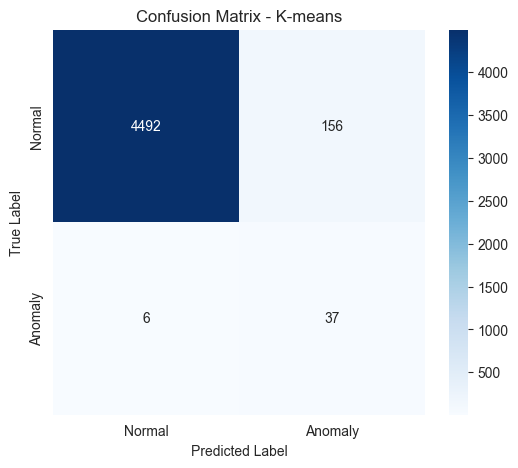

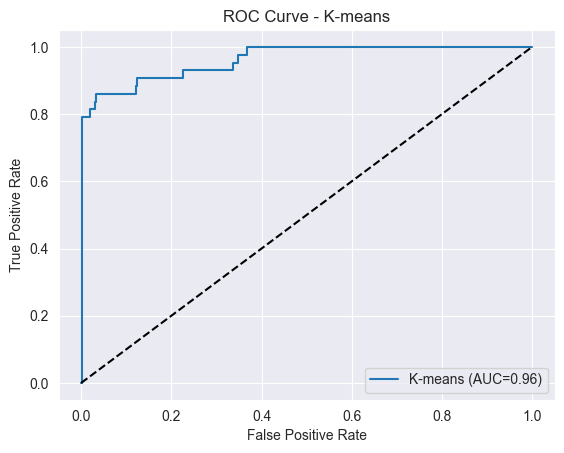

In [28]:
# Load saved scaler and K-means model
scaler_kmeans = joblib.load("../../Models/KMeans/scaler_kmeans_real.pkl")
kmeans = joblib.load("../../Models/KMeans/kmeans_model_real.pkl")

# Prepare data
X_test_kmeans = test_frames.reshape(len(test_frames), -1)
X_test_kmeans = scaler_kmeans.transform(X_test_kmeans)

# Measure inference time for K-means
start_time = time.time()
dist_test = kmeans.transform(X_test_kmeans).min(axis=1)
inference_time_kmeans = time.time() - start_time

# Determine threshold using the validation set distances (recompute if needed)
X_val_kmeans = val_frames.reshape(len(val_frames), -1)
X_val_kmeans = scaler_kmeans.transform(X_val_kmeans)
dist_val = kmeans.transform(X_val_kmeans).min(axis=1)
threshold_kmeans = np.percentile(dist_val, 97)

# Predict anomalies
y_pred_kmeans = (dist_test > threshold_kmeans).astype(int)

roc_auc_kmeans = roc_auc_score(test_labels, dist_test)
precision_kmeans, recall_kmeans, f1_kmeans, _ = precision_recall_fscore_support(test_labels, y_pred_kmeans,average='binary')
conf_kmeans = confusion_matrix(test_labels, y_pred_kmeans)

print("=== K-means Evaluation ===")
print(f"Threshold (95th percentile): {threshold_kmeans:.4f}")
print(f"ROC AUC: {roc_auc_kmeans:.4f}")
print(f"Precision: {precision_kmeans:.4f}, Recall: {recall_kmeans:.4f}, F1: {f1_kmeans:.4f}")
print(f"Inference time: {inference_time_kmeans:.4f} seconds")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_kmeans, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - K-means")
plt.show()

# Plot ROC Curve
fpr_k, tpr_k, _ = roc_curve(test_labels, dist_test)
plt.figure()
plt.plot(fpr_k, tpr_k, label=f'K-means (AUC={roc_auc_kmeans:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - K-means")
plt.legend()
plt.show()


### 5.2. Evaluate One-Class SVM


=== One-Class SVM Evaluation ===
ROC AUC: 0.9976
Precision: 0.1503, Recall: 1.0000, F1: 0.2614
Inference time: 12.1680 seconds


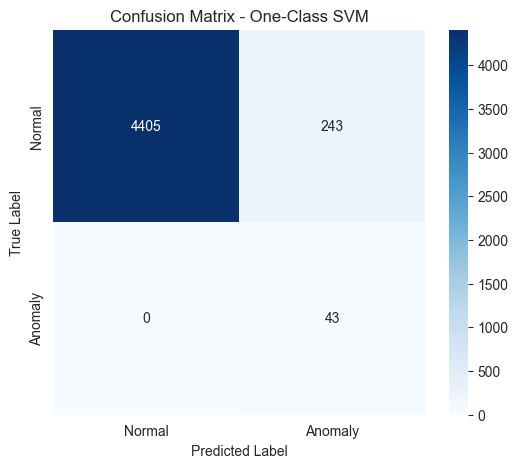

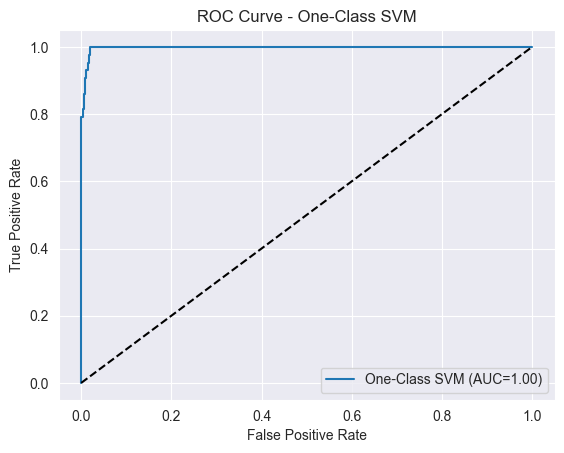

In [29]:
# Load saved scaler and One-Class SVM model
scaler_ocsvm = joblib.load("../../Models/OCSVM/scaler_ocsvm_real.pkl")
ocsvm = joblib.load("../../Models/OCSVM/ocsvm_model_real.pkl")

# Prepare data
X_test_ocsvm = test_frames.reshape(len(test_frames), -1)
X_test_ocsvm = scaler_ocsvm.transform(X_test_ocsvm)

# Measure inference time
start_time = time.time()
decision_scores = ocsvm.decision_function(X_test_ocsvm)
inference_time_ocsvm = time.time() - start_time

# For One-Class SVM, negative decision scores indicate anomalies
y_pred_ocsvm = (decision_scores < 0).astype(int)

roc_auc_ocsvm = roc_auc_score(test_labels, -decision_scores)
precision_ocsvm, recall_ocsvm, f1_ocsvm, _ = precision_recall_fscore_support(test_labels, y_pred_ocsvm,average='binary')
conf_ocsvm = confusion_matrix(test_labels, y_pred_ocsvm)

print("\n=== One-Class SVM Evaluation ===")
print(f"ROC AUC: {roc_auc_ocsvm:.4f}")
print(f"Precision: {precision_ocsvm:.4f}, Recall: {recall_ocsvm:.4f}, F1: {f1_ocsvm:.4f}")
print(f"Inference time: {inference_time_ocsvm:.4f} seconds")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_ocsvm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - One-Class SVM")
plt.show()

# Plot ROC Curve
fpr_oc, tpr_oc, _ = roc_curve(test_labels, -decision_scores)
plt.figure()
plt.plot(fpr_oc, tpr_oc, label=f'One-Class SVM (AUC={roc_auc_ocsvm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One-Class SVM")
plt.legend()
plt.show()


### 5.3. Evaluate LSTM Autoencoder

/var/folders/zd/dk56pvd12dsbsjgtmy8qr8h80000gn/T/ipykernel_4009/2444774879.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_ae.load_state_dict(torch.load("../../Mode


=== LSTM Autoencoder Evaluation ===
Threshold (95th percentile): 0.0028
ROC AUC: 0.9974
Precision: 0.2194, Recall: 1.0000, F1: 0.3598
Inference time: 0.8667 seconds


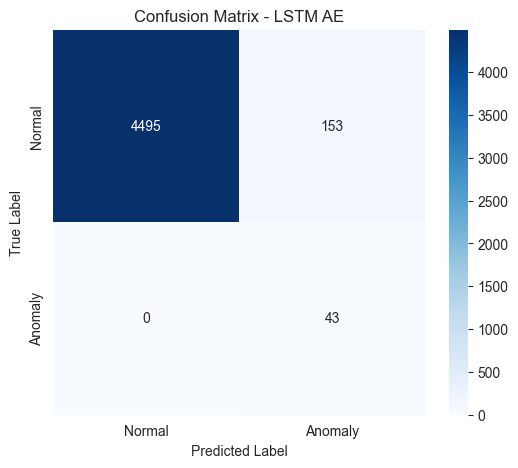

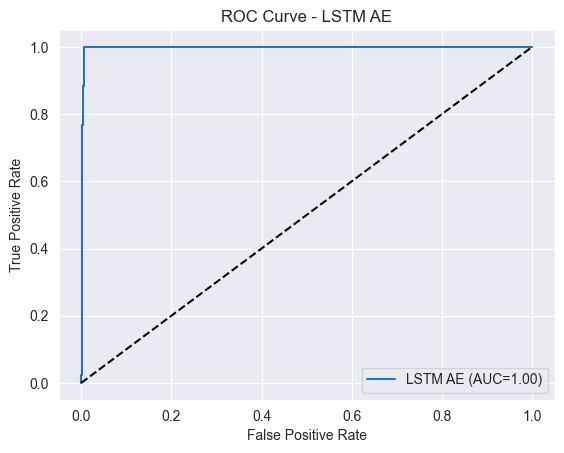

In [30]:
# Load the saved LSTM Autoencoder model
lstm_ae = LSTMAutoencoder(input_size=128, hidden_size=64, latent_size=32, num_layers=1)
lstm_ae.load_state_dict(torch.load("../../Models/LSTM_AE/lstm_ae_real.pth"))
lstm_ae = lstm_ae.float()
lstm_ae.eval()

# Compute reconstruction errors on test set
start_time = time.time()
with torch.no_grad():
    test_outputs = lstm_ae(test_frames_tensor_lstm)
    test_loss_tensor = nn.functional.mse_loss(test_outputs, test_frames_tensor_lstm, reduction='none')
    test_mse = test_loss_tensor.reshape(test_loss_tensor.size(0), -1).mean(dim=1).numpy()
inference_time_lstm = time.time() - start_time

# Recompute validation errors to set threshold
with torch.no_grad():
    val_outputs = lstm_ae(val_frames_tensor_lstm)
    val_loss_tensor = nn.functional.mse_loss(val_outputs, val_frames_tensor_lstm, reduction='none')
    val_mse = val_loss_tensor.reshape(val_loss_tensor.size(0), -1).mean(dim=1).numpy()
threshold_lstm = np.percentile(val_mse, 97)

y_pred_lstm = (test_mse > threshold_lstm).astype(int)

roc_auc_lstm = roc_auc_score(test_labels, test_mse)
precision_lstm, recall_lstm, f1_lstm, _ = precision_recall_fscore_support(test_labels, y_pred_lstm, average='binary')
conf_lstm = confusion_matrix(test_labels, y_pred_lstm)

print("\n=== LSTM Autoencoder Evaluation ===")
print(f"Threshold (95th percentile): {threshold_lstm:.4f}")
print(f"ROC AUC: {roc_auc_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}, F1: {f1_lstm:.4f}")
print(f"Inference time: {inference_time_lstm:.4f} seconds")

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM AE")
plt.show()

# Plot ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, test_mse)
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM AE (AUC={roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LSTM AE")
plt.legend()
plt.show()


## 6. Conclusion
#
We trained and evaluated three models on Mel-spectrogram frames:
1. **K-means Clustering**
2. **One-Class SVM**
3. **LSTM Autoencoder**
#
Each model used the same data-preparation pipeline. In the training section, we recorded training times and saved the models.
In the evaluation section, we loaded the saved models, computed ROC AUC, precision, recall, and F1-score,
plotted confusion matrices and ROC curves.
